In [1]:
import sys
sys.path.insert(0,'/home/lshtanko/Programming/another-fem-framework/')
#sys.path.insert(0,'/Users/marusy/Programming/another-fem-framework/')
#sys.path.insert(0,'/Users/leonshting/Programming/Schlumberger/fem-framework/')

In [2]:
from operator_assembler.assembly_interface import AssemblyInterface2D
from operator_assembler.n_to_1_ddof_allocator import Nto1Allocator2D
from grid.grid_manager import GridManager
from grid.allocator_interface import InterfaceDofAllocator2D
from grid.grid_domain import GridDomain
from operator_assembler.matrix_assembler import MatrixAssembler2D
from scipy.ndimage import imread
from grid import cell, grid_layer, grid_manager
import h5py
import numpy as np

from interpolant.cell_to_points import *
from common import visual
from common.tests import *
from common.helpers import *
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix, dok_matrix, coo_matrix
from scipy.sparse import linalg

%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 10

In [3]:
np.set_printoptions(linewidth=500)

#### Bad cell

In [4]:
data_start = (53, 98)
data_shape = (8, 8)
data_end = tuple([i+j for i,j in zip(data_start, data_shape)])

h5_data = h5py.File('../../../GM_L3D/600/state/viz_GM_1.h5')['index'][0]
data = h5_data[data_start[0]:data_end[0], data_start[1]:data_end[1]]
#data = imread('/Users/marusy/Programming/model/bhi2_labelled0000.tif')[data_start[0]:data_end[0], data_start[1]:data_end[1]]

grid_domain = GridDomain(integer_size=data_shape, domain_size=(1.,1.))
gm = GridManager(method_options={'max_coarsening_layer':2})
ifma = InterfaceDofAllocator2D(grid_manager=gm.fit(data=data))

In [ ]:
cell15 = cell.Cell2D(size=(1,1), ll_vertex=(0,8))
cell25 = cell.Cell2D(size=(1,1), ll_vertex=(0,9))

cell14 = cell.Cell2D(size=(1,1), ll_vertex=(0,6))
cell24 = cell.Cell2D(size=(1,1), ll_vertex=(0,7))

cell13 = cell.Cell2D(size=(1,1), ll_vertex=(0,4))
cell23 = cell.Cell2D(size=(1,1), ll_vertex=(0,5))

cell12 = cell.Cell2D(size=(1,1), ll_vertex=(0,2))
cell22 = cell.Cell2D(size=(1,1), ll_vertex=(0,3))

cell1 = cell.Cell2D(size=(1,1), ll_vertex=(0,0))
cell2 = cell.Cell2D(size=(1,1), ll_vertex=(0,1))

cell3 = cell.Cell2D(size=(2,2), ll_vertex=(1,0))
cell32 = cell.Cell2D(size=(2,2), ll_vertex=(1,2))
cell33 = cell.Cell2D(size=(2,2), ll_vertex=(1,4))
cell34 = cell.Cell2D(size=(2,2), ll_vertex=(1,6))
cell35 = cell.Cell2D(size=(2,2), ll_vertex=(1,8))

In [ ]:
layer1 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell1, cell2, cell12, cell22, cell13, cell23, cell14, cell24, cell15, cell25]], layer_number=0, index=[1,1], div_index=[1,1])
layer2 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell3, cell32, cell33, cell34, cell35]], layer_number=1, index=[1], div_index=[1])

#layer1 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell1, cell2]], layer_number=0, index=[1,1], div_index=[1,1])
#layer2 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell3]], layer_number=1, index=[1], div_index=[1])

In [ ]:
gm = grid_manager.GridManager(dim=2, method='coarse2to1')
gm.grid_layers = [layer1, layer2]
ifma = InterfaceDofAllocator2D(grid_manager=gm)

## setting the order of BF
#ifma._default_order = 3

In [5]:
ma = Nto1Allocator2D(grid_interface=ifma)
ma.make_complete_index()

In [6]:
grid_domain = GridDomain(domain_size=(3.,10.), integer_size=(3,10))
grid_domain.make_pointwise_index(ma)

In [7]:
ifma2 = AssemblyInterface2D(allocator=ma)
MA = MatrixAssembler2D(assembly_interface=ifma2, grid_domain=grid_domain)

In [8]:
MA.assemble_whole_dist()

100 (6, 6) [(5, 5)] []
37 (2, 4) [] [((2, 4), 168)]
209 (0, 2) [] []
104 (6, 4) [(5, 4)] []
9 (2, 2) [] [((2, 0), 153)]
168 (2, 4) [(1, 3)] []
49 (6, 6) [] [((6, 6), 100)]
82 (4, 4) [] [((2, 2), 169)]
169 (4, 4) [(4, 4)] []
73 (0, 4) [] []
153 (2, 2) [(1, 2)] []
120 (4, 6) [(4, 5)] []
25 (6, 4) [] [((6, 2), 104)]
91 (0, 2) [] []
61 (4, 6) [] [((2, 6), 120)]
222 (0, 4) [] []


In [9]:
MA.assemble_glob_local(normed=False)

In [10]:
MA.assemble_mass_glob_local()

In [11]:
new = MA.unmerged * MA.whole_dist
new_ass = MA.whole_dist.T * MA.unmerged * MA.whole_dist
flux_new = MA.whole_dist.T * MA.unmerged

In [ ]:
aaaa = linalg.inv(MA.whole_dist) * MA.unmerged * MA.whole_dist

In [ ]:
new_mass = MA.whole_dist.T * MA.mass_unmerged * MA.whole_dist

In [ ]:
plt.imshow(linalg.inv(new_mass).toarray(), interpolation='none')

In [ ]:
sine_test = grid_domain.vectorize_function(lambda x,y: np.sin(x+y))
product = grid_domain.devectorize_vector(new_ass * sine_test)
init = grid_domain.devectorize_function(lambda x,y: np.sin(x+y))

visual.plot_surface_unstructured_w_dict(
    point_val_dict=grid_domain.devectorize_vector(new_ass * sine_test),
    plot_domain_shape=grid_domain.domain_size,
    int_domain_shape=grid_domain.integer_size
)

#visual.plot_surface_unstructured_w_dict(
#    point_val_dict=grid_domain.devectorize_function(lambda x,y: np.sin(x+y)),
#    plot_domain_shape=grid_domain.domain_size,
#    int_domain_shape=grid_domain.integer_size
#)

In [ ]:
gm.draw_grid()

In [ ]:
grid_domain.pointwise_index[(4.0, 4.0)]

In [ ]:
for k,v in ma._vertex_ddof_index.items():
    if(k[1] == (8,4)):
        print(k,v)

In [ ]:
-2617367748.898792/-456230700.7852787

In [20]:
for i in {82, 169}:
    print(i, end=' ')
    partial_diff_test(matrix=flux_new,
                      point=grid_domain.normal_index[i],
                      pointnum=i,
                      pointdict=grid_domain.pointwise_index,
                      scale_factor=1
                     )

169 zero derivative: 1.1247760311575245e-13
X derivative: 0.004274962715058991
Y derivative: 0.004274962709238919
XX derivative: -0.05635843017177225
YY derivative: -0.0563584301813587
XY_derivative: -0.00854645289678349

82 zero derivative: 5.826979523892994e-14
X derivative: -0.004274242997089507
Y derivative: -0.004274243006427947
XX derivative: -0.020031312552205277
YY derivative: -0.020031312555239163
XY_derivative: 0.00855783749412322



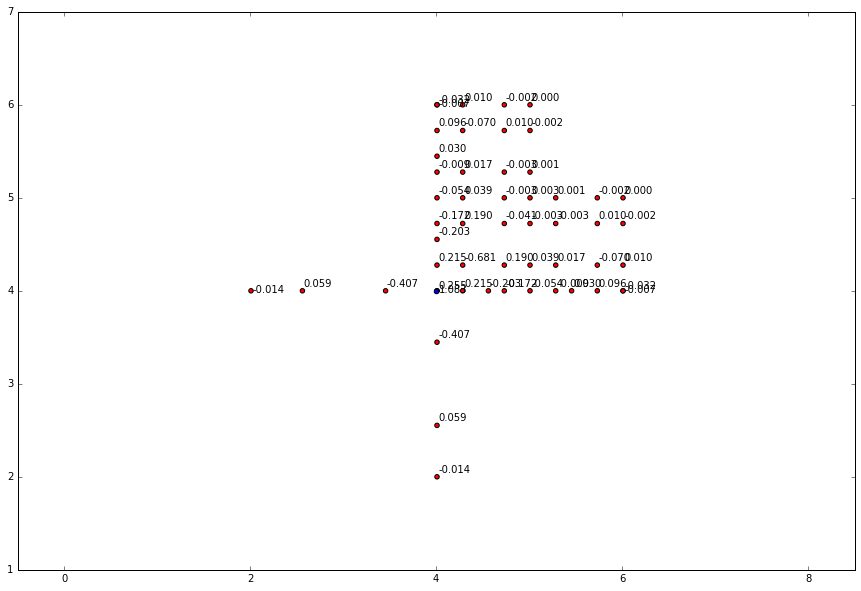

In [19]:
for num,i in enumerate({169}):
    visual.deps_partial_diff(
        matrix=flux_new,
        pointnum=i, num2point_index=grid_domain.normal_index,
        print_text=True,
        p2n_index = grid_domain.pointwise_index
    )


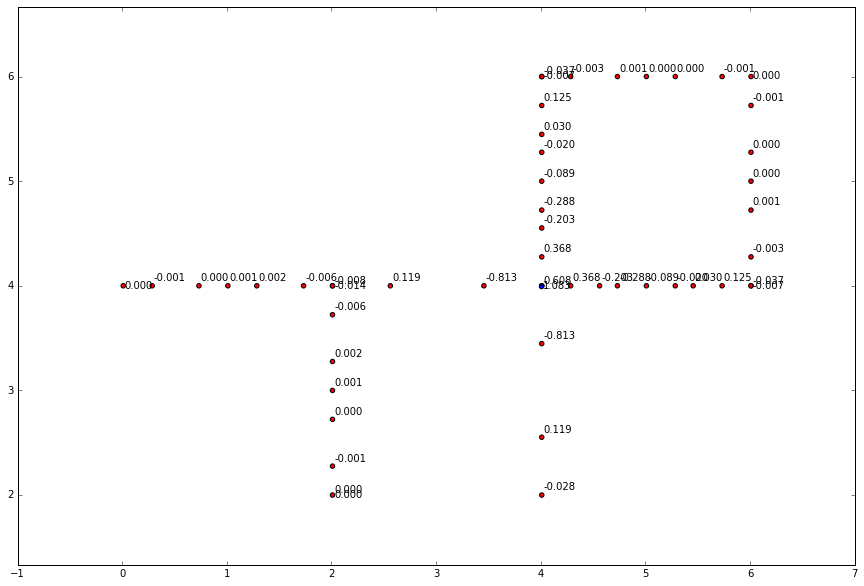

In [16]:
for num,i in enumerate({169}):
    visual.deps_partial_diff(
        matrix=new,
        pointnum=i, num2point_index=grid_domain.normal_index,
        print_text=True,
        p2n_index = grid_domain.pointwise_index
    )


In [ ]:
w = np.array([0.042,  0.208,  0.208,  0.083,  0.208,  0.208,  0.042])
w_t = concat_arrays_with_adjacency(w,w,)

In [ ]:
coefs = np.array([-0.026, 0.035, -0.008, -0.042, -0.069, 0.168, 0.801])
coefs_t = np.hstack([coefs, coefs[:-1][::-1]])

In [ ]:
0.11/0.042

In [ ]:
sum(w_t*coefs_t)

In [ ]:
pipka = wdt.T * MA.unmerged

In [ ]:
wdt[247].sum(axis=1)

In [ ]:
MA.whole_dist[419].sum()

In [ ]:
np.argsort(np.array(MA.dist.sum(axis=1)).flatten())

In [ ]:
plt.imshow(MA.dist.toarray())

In [ ]:
a = np.array([0.5, 0.54])

In [ ]:
a**0.5

In [ ]:
new_eff